# Modeling Process With Experimental Feature Database

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config
set_config(print_changed_only=False)
from xgboost import XGBClassifier
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', 300)
%matplotlib inline

plt.style.use('seaborn')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [ ]:
exp_df = pd.read_csv('experiment_features.csv',index_col=0)
exp_df.head()

vanilla_df = pd.read_csv('fetal_health.csv')
X = vanilla_df.drop('fetal_health', axis =1)


In [ ]:
def evaluation(y_true, y_pred):
    
    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
    
    print('\nConfusion Matrix:')
    print(' TN,  FP, FN, TP')
    print(confusion_matrix(y_true, y_pred).ravel())
    

def print_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_))   

In [ ]:
X = exp_df.drop('fetal_health', axis =1)
y = exp_df.fetal_health

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=1)

In [ ]:
scaler = StandardScaler()  
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

## Class imbalance

In [ ]:
sm = SMOTE(random_state=25)
smX_train, smy_train = sm.fit_sample(X_train, y_train)

## KNN 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9172932330827067
Recall: 0.9682151589242054
F1 Score: 0.9473684210526316
Precision: 0.927400468384075

Confusion Matrix:
 TN,  FP, FN, TP
[396  13  31  92]


In [ ]:
smknn = KNeighborsClassifier(n_neighbors=1)
smknn.fit(smX_train,smy_train)
y_pred = smknn.predict(X_test)

In [ ]:
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9172932330827067
Recall: 0.9584352078239609
F1 Score: 0.9468599033816426
Precision: 0.9355608591885441

Confusion Matrix:
 TN,  FP, FN, TP
[392  17  27  96]


## Logistic Regression Basline Model

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [ ]:
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.8796992481203008
Recall: 0.9388753056234719
F1 Score: 0.9230769230769231
Precision: 0.9078014184397163

Confusion Matrix:
 TN,  FP, FN, TP
[384  25  39  84]


In [ ]:
smlr = LogisticRegression(solver='liblinear')
smlr.fit(smX_train,smy_train)
y_predsm = smlr.predict(X_test)

In [ ]:
evaluation(y_test, y_predsm)

Evaluation Metrics:
Accuracy: 0.8853383458646616
Recall: 0.8801955990220048
F1 Score: 0.9218950064020486
Precision: 0.967741935483871

Confusion Matrix:
 TN,  FP, FN, TP
[360  49  12 111]


In [ ]:
smX_train_1=pd.DataFrame(smX_train)


In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train_1.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',smlr.coef_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','Coefs','del','sm_Coefs']
del smote_vs_coef['del']
smote_vs_coef

,features,Coefs,sm_Coefs
0,baseline value,0.117187,0.132509
1,accelerations,-0.004096,-0.251781
2,fetal_movement,0.010856,0.351941
3,uterine_contractions,-0.005326,-0.059394
4,light_decelerations,-0.002222,-0.041308
5,prolongued_decelerations,0.000807,0.047737
6,abnormal_short_term_variability,0.070440,0.095303
7,mean_value_of_short_term_variability,-0.715728,-0.573296
8,percentage_of_time_with_abnormal_long_term_var...,0.037100,0.036719
9,mean_value_of_long_term_variability,0.032967,0.048317


In [ ]:
from sklearn.ensemble import BaggingClassifier
bag_log = BaggingClassifier(
    base_estimator=LogisticRegression(
        random_state=1),n_estimators=200,
    max_samples=.85,
    max_features=10,oob_score=True,
    n_jobs=-1,verbose=1)

In [ ]:
bag_log.fit(smX_train, smy_train)
y_pred = bag_log.predict(X_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


In [ ]:
evaluation(y_test,y_pred)

Evaluation Metrics:
Accuracy: 0.8665413533834586
Recall: 0.8606356968215159
F1 Score: 0.9083870967741935
Precision: 0.9617486338797814

Confusion Matrix:
 TN,  FP, FN, TP
[352  57  14 109]


## Decision Tree

In [ ]:
tree = DecisionTreeClassifier()

tree = tree.fit(X_train,y_train)

y_pred = tree.predict(X_test)

In [ ]:
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9191729323308271
Recall: 0.9339853300733496
F1 Score: 0.9467162329615861
Precision: 0.9597989949748744

Confusion Matrix:
 TN,  FP, FN, TP
[382  27  16 107]


In [ ]:
smtree = DecisionTreeClassifier()
smtree.fit(smX_train,smy_train)
y_pred = smtree.predict(X_test)

In [ ]:
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9379699248120301
Recall: 0.9657701711491442
F1 Score: 0.959902794653706
Precision: 0.9541062801932367

Confusion Matrix:
 TN,  FP, FN, TP
[395  14  19 104]


In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",tree.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train_1.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',tree.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance','del','sm_importance']
del smote_vs_coef['del']
smote_vs_coef

,features,importance,sm_importance
0,baseline value,0.042665,0.042665
1,accelerations,0.019693,0.019693
2,fetal_movement,0.016659,0.016659
3,uterine_contractions,0.003420,0.003420
4,light_decelerations,0.002762,0.002762
5,prolongued_decelerations,0.028585,0.028585
6,abnormal_short_term_variability,0.335788,0.335788
7,mean_value_of_short_term_variability,0.117288,0.117288
8,percentage_of_time_with_abnormal_long_term_var...,0.041862,0.041862
9,mean_value_of_long_term_variability,0.019097,0.019097


## Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state =1, n_estimators= 50, max_depth = 3, n_jobs =-1,verbose=1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [ ]:
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.900375939849624
Recall: 0.9828850855745721
F1 Score: 0.9381563593932323
Precision: 0.8973214285714286

Confusion Matrix:
 TN,  FP, FN, TP
[402   7  46  77]


In [ ]:
smrfc = RandomForestClassifier(random_state =1, n_estimators= 50, max_depth = 3, n_jobs =-1,verbose=1)
smrfc.fit(smX_train,smy_train)
y_pred = smrfc.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [ ]:
print(confusion_matrix(y_test, y_pred))
evaluation(y_test, y_pred)

[[381  28]
 [ 16 107]]
Evaluation Metrics:
Accuracy: 0.9172932330827067
Recall: 0.9315403422982885
F1 Score: 0.9454094292803971
Precision: 0.9596977329974811

Confusion Matrix:
 TN,  FP, FN, TP
[381  28  16 107]


In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",rfc.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train_1.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',smrfc.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance_baseline','del','sm_importance_baseline']
del smote_vs_coef['del']
smote_vs_coef

,features,importance_baseline,sm_importance_baseline
0,baseline value,9.926765e-03,0.016188
1,accelerations,1.035325e-01,0.196017
2,fetal_movement,4.708818e-03,0.002176
3,uterine_contractions,1.058922e-02,0.018089
4,light_decelerations,6.170803e-04,0.001520
5,prolongued_decelerations,8.764041e-02,0.084955
6,abnormal_short_term_variability,1.576849e-01,0.181858
7,mean_value_of_short_term_variability,1.492258e-01,0.106684
8,percentage_of_time_with_abnormal_long_term_var...,8.983866e-02,0.084788
9,mean_value_of_long_term_variability,1.227784e-02,0.010061


## Grid Search Random Forest


In [ ]:
parameters = {
    'n_estimators': [25,50,100,300,500],
    'criterion' : ['gini','entropy'],
    'max_depth' : [8,9,10,11,12],
    'max_features' : ['sqrt'],
    'min_weight_fraction_leaf' : [0,0.1,0.3,0.5],
    
    
    
}

In [ ]:
grid_tree=GridSearchCV(RandomForestClassifier(), parameters, cv=15, scoring='f1', verbose=1, n_jobs=-1)

In [ ]:
grid_tree.fit(smX_train, smy_train)

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 23.4min finished


GridSearchCV(cv=15, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

0.9761008979552065
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_weight_fraction_leaf': 0, 'n_estimators': 50}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0, n_estimators=50, n_jobs=None,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
y_pred = grid_tree.best_estimator_.predict(X_test)
evaluation(y_test,y_pred)

Evaluation Metrics:
Accuracy: 0.9492481203007519
Recall: 0.9706601466992665
F1 Score: 0.9671132764920828
Precision: 0.9635922330097088

Confusion Matrix:
 TN,  FP, FN, TP
[397  12  15 108]


In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",grid_tree.best_estimator_.feature_importances_.transpose())
coef_table

,0,Coefs
0,baseline value,0.022117
1,accelerations,0.130221
2,fetal_movement,0.018725
3,uterine_contractions,0.031353
4,light_decelerations,0.007721
5,prolongued_decelerations,0.047052
6,abnormal_short_term_variability,0.161897
7,mean_value_of_short_term_variability,0.079979
8,percentage_of_time_with_abnormal_long_term_var...,0.062785
9,mean_value_of_long_term_variability,0.019524


In [ ]:
coef_table.columns = ['features','grid_search_importance']
del coef_table['features']
best_features_rfc = pd.concat([smote_vs_coef,coef_table],axis=1)

In [ ]:
best_features_rfc

,features,importance_baseline,sm_importance_baseline,grid_search_importance
0,baseline value,9.926765e-03,0.016188,0.022117
1,accelerations,1.035325e-01,0.196017,0.130221
2,fetal_movement,4.708818e-03,0.002176,0.018725
3,uterine_contractions,1.058922e-02,0.018089,0.031353
4,light_decelerations,6.170803e-04,0.001520,0.007721
5,prolongued_decelerations,8.764041e-02,0.084955,0.047052
6,abnormal_short_term_variability,1.576849e-01,0.181858,0.161897
7,mean_value_of_short_term_variability,1.492258e-01,0.106684,0.079979
8,percentage_of_time_with_abnormal_long_term_var...,8.983866e-02,0.084788,0.062785
9,mean_value_of_long_term_variability,1.227784e-02,0.010061,0.019524


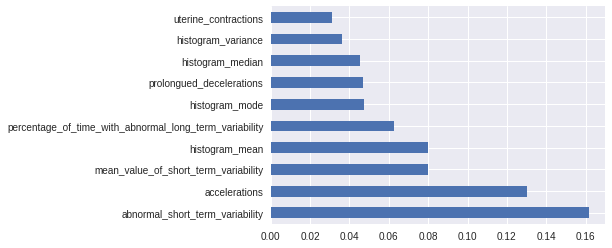

In [ ]:
pd.Series(grid_tree.best_estimator_.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')

## XGboost

In [ ]:
from xgboost import XGBClassifier
xgb=XGBClassifier()

In [ ]:
xg_clf = XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.75, 
                           subsample = 0.85,
                           learning_rate = 0.1,
                           max_depth = 11, 
                           alpha = 1, 
                           n_estimators = 1000,
                          verbose=1, n_jobs=-1)

In [ ]:
xg_clf.fit(smX_train,smy_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbose=1, verbosity=1)

In [ ]:
y_pred = xg_clf.predict(X_test.values)

In [ ]:
evaluation(y_test,y_pred)

Evaluation Metrics:
Accuracy: 0.9605263157894737
Recall: 0.9828850855745721
F1 Score: 0.9745454545454545
Precision: 0.9663461538461539

Confusion Matrix:
 TN,  FP, FN, TP
[402   7  14 109]


In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",xg_clf.feature_importances_.transpose())

In [ ]:
coef_table

,0,Coefs
0,baseline value,0.012179
1,accelerations,0.170285
2,fetal_movement,0.014384
3,uterine_contractions,0.022601
4,light_decelerations,0.008957
5,prolongued_decelerations,0.121696
6,abnormal_short_term_variability,0.103411
7,mean_value_of_short_term_variability,0.054614
8,percentage_of_time_with_abnormal_long_term_var...,0.013397
9,mean_value_of_long_term_variability,0.006687


In [ ]:
clf_xgb = XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [500,1000,1500],
              'learning_rate': [0.1,0.07,0.05,0.03,0.01],
              'max_depth': [9,10,11,12,13],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3]
             }

In [ ]:
grid_xg = GridSearchCV(estimator=clf_xgb,
                      param_grid= param_dist,
                      scoring='f1',
                      n_jobs=-1,
                      verbose=1,
                      iid=False,
                      cv=10)

In [ ]:
grid_xg.fit(smX_train,smy_train)

Fitting 10 folds for each of 675 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 69.5min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 103.4min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 128.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 162.9min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 203.5min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 240.5min
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed: 275.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.45, 0.4],
                         'learning_rate': [0.1, 0.07, 0.05, 0.03, 0.01],
                         'max_depth': [9, 10, 11,

In [ ]:
grid_xg.best_params_

{'colsample_bytree': 0.45,
 'learning_rate': 0.07,
 'max_depth': 12,
 'min_child_weight': 2,
 'n_estimators': 500}

In [ ]:
y_pred = grid_xg.best_estimator_.predict(X_test.values)

In [ ]:
evaluation(y_test,y_pred)

Evaluation Metrics:
Accuracy: 0.9605263157894737
Recall: 0.9853300733496333
F1 Score: 0.9746070133010883
Precision: 0.9641148325358851

Confusion Matrix:
 TN,  FP, FN, TP
[403   6  15 108]


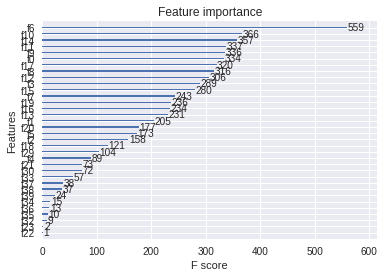

In [ ]:
from xgboost import plot_importance
plot_importance(grid_xg.best_estimator_)

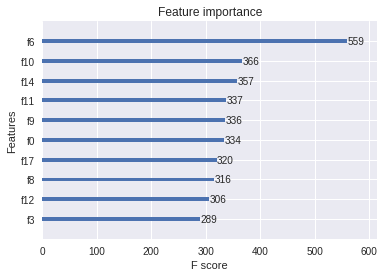

In [ ]:
plot_importance(grid_xg.best_estimator_,max_num_features=10)